[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

This demo solves DoomBasic env with a simple q-learning with experience replay.

Video observation forces you to use ```CNN```

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cpu, floatX=float32

env: THEANO_FLAGS=device=cpu, floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomBasic-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80, height=80, grayscale=True)

env = make_env()

[2017-08-23 06:55:08,055] Making new env: ppaquette/DoomBasic-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

#number of parallel agents and batch sequence length (frames)
SEQ_LENGTH = 10
FRAME_NUMBER = 4
print("observation shape:", observation_shape)
print("n_action:", n_actions)

observation shape: (1, 80, 80)
n_action: 4


-10.0 False
(1, 80, 80)


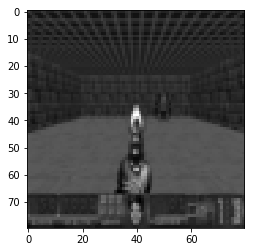

In [4]:
env.reset()
obs, r, done, _ = env.step(1)
print(r, done)
print(np.shape(obs))
plt.imshow(obs[0], cmap='gray', interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cpu, floatX=float32

import theano, lasagne
from lasagne.layers import *

from agentnet.memory import WindowAugmentation, LSTMCell
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.target_network import TargetNetwork
from agentnet.experiments.openai_gym.pool import EnvPool

env: THEANO_FLAGS=device=cpu, floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)
print("shape of observation layer", (None,)+observation_shape)

#4-tick window over images
prev_wnd = InputLayer((None, FRAME_NUMBER)+observation_shape)
print("shape of prev wnd", (None, FRAME_NUMBER)+observation_shape)
new_wnd = WindowAugmentation(observation_layer, prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1, FRAME_NUMBER*observation_shape[0])+observation_shape[1:])
print("reshape to", (-1, FRAME_NUMBER*observation_shape[0])+observation_shape[1:])

shape of observation layer (None, 1, 80, 80)
shape of prev wnd (None, 4, 1, 80, 80)
reshape to (-1, 4, 80, 80)


Now, define your NN which probably solve the environment. 

#### Tips:
1. Main component are likely to be ```Conv2D``` and ```Pool2DLayer```
2. Batch normalization here might speeds up training but may get unstable if you use small experience replay buffer
3. Last layers should be Dense

In [7]:
from lasagne.nonlinearities import elu, tanh, softmax
net = {}
net['conv1_1'] = Conv2DLayer(wnd_reshape, 32, 3, pad=1)
net['conv1_2'] = Conv2DLayer(net['conv1_1'], 32, 3, pad=1)
net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
net['conv2_1'] = Conv2DLayer(net['pool1'], 32, 3, pad=1)
net['conv2_2'] = Conv2DLayer(net['conv2_1'], 32, 3, pad=1)
net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
dense = DenseLayer(net['pool2'], num_units=64)

In [8]:
#baseline for all qvalues
qvalues_layer = DenseLayer(dense, num_units=n_actions, nonlinearity=None, name='qval')
        
#sample actions proportionally to policy_layer
action_layer = EpsilonGreedyResolver(qvalues_layer)

In [9]:
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together

agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer, qvalues_old),
              agent_states={new_wnd: prev_wnd},
              action_layers=action_layer)

In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer, trainable=True)
weights

[W, b, W, b, W, b, W, b, W, b, qval.W, qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
pool = EnvPool(agent,
               make_env, 
               n_games=4, #parallel games (only 1 so far)
               max_size=1000) #experience replay pool holding last 1k sessions

[2017-08-23 06:55:09,428] Making new env: ppaquette/DoomBasic-v0
[2017-08-23 06:55:09,450] Making new env: ppaquette/DoomBasic-v0
[2017-08-23 06:55:09,470] Making new env: ppaquette/DoomBasic-v0
[2017-08-23 06:55:09,496] Making new env: ppaquette/DoomBasic-v0


In [13]:
%%time
#interact for 7 ticks
_, action_log, reward_log, _, _, _ = pool.interact(7)

print(action_log)
print(reward_log)

[[2 2 2 2 2 2 0]
 [2 2 2 2 1 2 3]
 [3 2 2 3 2 2 1]
 [2 2 2 2 2 2 0]]
[[ -5.  -5.  -5.  -5.  -5.  -5.   0.]
 [ -5.  -5.  -5.  -5. -10.  -5.   0.]
 [ -5.  -5.  -5.  -5.  -5.  -5.   0.]
 [ -5.  -5.  -5.  -5.  -5.  -5.   0.]]
CPU times: user 780 ms, sys: 1.09 s, total: 1.87 s
Wall time: 791 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(64, replace=True)

_, _, _, _, (qvalues_seq, old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True
)

In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
grad = T.grad(loss, weights)
updates = lasagne.updates.adam(grad,
                               weights,
                               learning_rate=0.0001)

train_step = theano.function([], loss, updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records", record_video = True, n_games=10))

[2017-08-23 06:55:23,459] Making new env: ppaquette/DoomBasic-v0
[2017-08-23 06:55:23,500] Clearing 8 monitor files from previous run (because force=True was provided)
[2017-08-23 06:55:23,836] Starting new video recorder writing to /notebooks/week4/records/openaigym.video.0.50.video000000.mp4


Episode finished after 70 timesteps with reward=-350.0


[2017-08-23 06:55:28,188] Starting new video recorder writing to /notebooks/week4/records/openaigym.video.0.50.video000001.mp4


Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0


[2017-08-23 06:55:45,763] Starting new video recorder writing to /notebooks/week4/records/openaigym.video.0.50.video000008.mp4


Episode finished after 70 timesteps with reward=-350.0
Episode finished after 70 timesteps with reward=-350.0


[2017-08-23 06:55:51,578] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week4/records')


Episode finished after 70 timesteps with reward=-350.0


# Training loop

In [19]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0: untrained_reward}

If you don't have ```tqdm```, remove the first line and ```tqdm_notebook``` from second line

Loop may take years to finish.

You may consider interrupting early.

In [20]:
#the loop may take eons to finish.
#consider interrupting early.

for i in range(2000):  
   
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

# Time to drink some coffee!

iter=10	epsilon=0.954	reward/step=-3.68864
iter=20	epsilon=0.910	reward/step=-3.43571
iter=30	epsilon=0.868	reward/step=-3.58387
iter=40	epsilon=0.828	reward/step=-3.85427


KeyboardInterrupt: 

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
time,rw = zip(*sorted(list(rewards.items()), key=lambda p: p[0]))
plt.plot(time, map(np.mean,rw))
    

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20, save_path="./records", record_video=True)
print("mean session score=%f.5"%np.mean(rw))

In [ ]:
from agentnet.utils.persistence import save,load
#save for display
#save(action_layer,"doombasic_dqn_2000.pcl")

In [ ]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = filter(lambda s: s.endswith(".mp4"), os.listdir("./records/"))
video_path = "./records/" + choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Homework II
Get it work. We want stable positive score :)

## Bonus assignment II
* Better env
  * Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch __or__ any atari game you want.
  * Try to get `better_than_random` score on any of those environments __(2+++ pts)__
  * Deploy a better network. Doom will likely need some recurrent netsle
     * Find an arcitecture which maxsimizes score __(bonus points depend on your ```mean_reward```)__  
     * Bonus can get large as you approach state-of-the-art
     
* Deploy a different RL algorithm
  * Try at least two RL algorithms which had been learned during the course and try to compare them on ```mean_reward``` with similar training time (**plot** or **table** would be good idea) __(3 pts)__
  * See the note in assignment 4.1 on how to train on-policy
  
  
